In [104]:
import pandas as pd
import numpy as np

# Load your CSV file
file_path = r'D:\utils\WitMotion(V2024.12.27.0)\Record\2025-03-25\09-16-06-134\data_0.csv'  # <-- Replace with your file path
df = pd.read_csv(file_path,sep=',', usecols=range(20), encoding='utf-8-sig')

display(df.head())
print(df.columns.tolist())



,Time,Device name,Chip Time(),Acceleration X(g),Acceleration Y(g),Acceleration Z(g),Angular velocity X(°/s),Angular velocity Y(°/s),Angular velocity Z(°/s),Angle X(°),Angle Y(°),Angle Z(°),Magnetic field X(ʯt),Magnetic field Y(ʯt),Magnetic field Z(ʯt),Temperature(℃),Quaternions 0(),Quaternions 1(),Quaternions 2(),Quaternions 3()
0,09:16:06.162,f3:89:79:49:6c:b3,2015-01-01 00:56:09.620,-0.004,0.000,1.000,-3.357,0.061,-2.014,-0.308,3.318,-172.914,-3.038,-16.072,7.546,26.13,-0.06171,0.00113,-0.04959,0.99683
1,09:16:06.166,f3:89:79:49:6c:b3,2015-01-01 00:56:09.620,0.000,0.002,0.999,-3.479,0.183,-2.075,-0.308,3.318,-172.908,-3.038,-16.072,7.546,26.13,-0.06171,0.00113,-0.04959,0.99683
2,09:16:06.166,f3:89:79:49:6c:b3,2015-01-01 00:56:09.620,0.000,0.010,0.999,-3.479,0.183,-1.953,-0.308,3.318,-172.908,-3.038,-16.072,7.546,26.13,-0.06171,0.00113,-0.04959,0.99683
3,09:16:06.166,f3:89:79:49:6c:b3,2015-01-01 00:56:09.620,0.000,0.003,1.001,-3.418,0.305,-1.892,-0.308,3.318,-172.908,-3.038,-16.072,7.546,26.13,-0.06171,0.00113,-0.04959,0.99683
4,09:16:06.166,f3:89:79:49:6c:b3,2015-01-01 00:56:09.620,-0.001,0.000,0.999,-3.296,0.183,-2.197,-0.308,3.318,-172.908,-3.038,-16.072,7.546,26.13,-0.06171,0.00113,-0.04959,0.99683


['Time', 'Device name', 'Chip Time()', 'Acceleration X(g)', 'Acceleration Y(g)', 'Acceleration Z(g)', 'Angular velocity X(°/s)', 'Angular velocity Y(°/s)', 'Angular velocity Z(°/s)', 'Angle X(°)', 'Angle Y(°)', 'Angle Z(°)', 'Magnetic field X(ʯt)', 'Magnetic field Y(ʯt)', 'Magnetic field Z(ʯt)', 'Temperature(℃)', 'Quaternions 0()', 'Quaternions 1()', 'Quaternions 2()', 'Quaternions 3()']


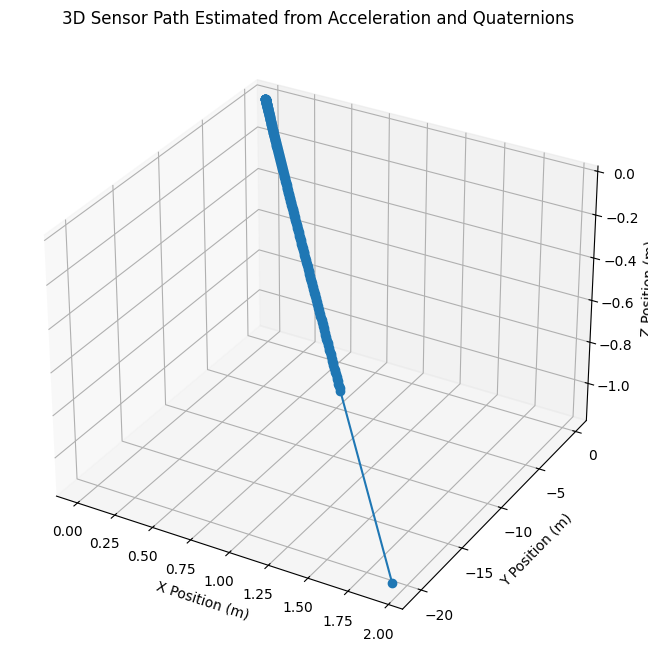

In [107]:
# 2. Convert Chip Time() to numeric seconds
df['Chip Time()'] = pd.to_datetime(df['Chip Time()'])
df['elapsed_s'] = (df['Chip Time()'] - df['Chip Time()'].iloc[0]).dt.total_seconds()

# 3. Extract data
quat_w = df['Quaternions 0()'].values
quat_x = df['Quaternions 1()'].values
quat_y = df['Quaternions 2()'].values
quat_z = df['Quaternions 3()'].fillna(0).values
quaternions = np.vstack([quat_w, quat_x, quat_y, quat_z]).T

g = 9.80665
accel_sensor = df[['Acceleration X(g)',
                   'Acceleration Y(g)',
                   'Acceleration Z(g)']].values * g

# Use numeric time in seconds
#time = df['elapsed_s'].values

fs = 50  # or 100, depending on your sampling rate
dt = 1 / fs
time = np.arange(len(df)) * dt

# 4. Function to convert quaternion -> rotation matrix
def quaternion_to_rotation_matrix(q):
    w, x, y, z = q
    norm = np.sqrt(w*w + x*x + y*y + z*z)
    if norm == 0:
        return np.eye(3)
    w /= norm
    x /= norm
    y /= norm
    z /= norm

    R = np.array([
        [1 - 2*(y**2 + z**2), 2*(x*y - z*w),     2*(x*z + y*w)],
        [2*(x*y + z*w),       1 - 2*(x**2 + z**2), 2*(y*z - x*w)],
        [2*(x*z - y*w),       2*(y*z + x*w),     1 - 2*(x**2 + y**2)]
    ])
    return R

# 5. Calculate accel in world frame
accel_world = []
gravity_world = np.array([0, 0, g])

for i in range(len(df)):
    R = quaternion_to_rotation_matrix(quaternions[i])
    gravity_sensor = R.T @ gravity_world
    linear_accel_sensor = accel_sensor[i] - gravity_sensor
    linear_accel_world = R @ linear_accel_sensor
    accel_world.append(linear_accel_world)

accel_world = np.array(accel_world)

# 6. Integrate to get velocity & position
velocity_world = cumulative_trapezoid(accel_world, x=time, axis=0, initial=0)
position_world = cumulative_trapezoid(velocity_world, x=time, axis=0, initial=0)

# 7. (Optional) Outlier removal
displacements = np.linalg.norm(np.diff(position_world, axis=0), axis=1)
threshold = np.mean(displacements) + 1 * np.std(displacements)
valid_points_mask = np.ones(len(position_world), dtype=bool)
for i in range(1, len(displacements)):
    if displacements[i - 1] > threshold:
        valid_points_mask[i] = False
position_world_filtered = position_world[valid_points_mask]

# 8. Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(position_world_filtered[:, 0],
        position_world_filtered[:, 1],
        position_world_filtered[:, 2],
        marker='o', linestyle='-')
ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')
ax.set_zlabel('Z Position (m)')
ax.set_title('3D Sensor Path Estimated from Acceleration and Quaternions')
plt.show()

In [ ]:
from pathlib import Path

# Load binary file
file_path = Path("/mnt/data/data_0.bin")
with open(file_path, "rb") as f:
    data = f.read()

# Function to extract 0x55 0x61 packets (20 bytes)
def extract_61_packets(binary_data):
    packets = []
    i = 0
    while i < len(binary_data) - 20:
        if binary_data[i] == 0x55 and binary_data[i+1] == 0x61:
            packet = binary_data[i:i+20]
            if len(packet) == 20:
                packets.append(packet)
            i += 20
        else:
            i += 1
    return packets

# Extract packets and get first and last
packets_61 = extract_61_packets(data)
first_packet = packets_61[0] if packets_61 else None
last_packet = packets_61[-1] if packets_61 else None

first_packet_hex = first_packet.hex(" ").upper() if first_packet else "None"
last_packet_hex = last_packet.hex(" ").upper() if last_packet else "None"

first_packet_hex, last_packet_hex
